Code for determining how to adjust VonMises dispersion parameter in cursor probabilistic model based on proximity to target.

We'll use a logistic function (as seen below) with parametrized midpoint and steepness.

In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import sys
sys.path.append('../utils/plotting/')
sys.path.append('../utils/recalibration/')
sys.path.append('../utils/simulation/')
from plotting_utils import figSize
from hmm import HMMRecalibration
from simulation import simulateBCIFitts
import simulation_utils


# for a reproducible result
np.random.seed(1)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### **Define an initial decoder and initial neural tuning properties (mean firing rates and preferred directions)**


In [15]:
from sklearn.linear_model import LinearRegression

nUnits         = 192
SNR            = 0.5
nTrainingSteps = 10000

initialTuning          = simulation_utils.generateUnits(n_units = nUnits, SNR = SNR)
calNeural, calVelocity = simulation_utils.simulateUnitActivity(initialTuning, noise = 0.3, nSteps = nTrainingSteps)
lr                     = LinearRegression(fit_intercept = True).fit(calNeural, calVelocity)
D                      = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_]).T

# Normalize the gain of this decoder so that it will output vectors with a magnitude of 1 when the encoded velocity has a magnitude of 1. 
D[:, 0] = D[:,0] / np.linalg.norm(D[1:, :][:, 0]) / np.linalg.norm(initialTuning[:, 1])
D[:, 1] = D[:,1] / np.linalg.norm(D[1:, :][:, 1]) / np.linalg.norm(initialTuning[:, 2])


Here we define the amount of exponential smoothing used in the decoder (alpha). Values between 0.9 and 0.96 are pretty reasonable. We then do a sweep for beta.

In [3]:
cfg = dict()
cfg['neuralTuning'] = initialTuning
cfg['D']            = D
cfg['alpha']        = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
cfg['delT']         = 0.02 # define the time step (20 ms)
cfg['nDelaySteps']  = 10   # define the simulated user's visual feedback delay (200 ms)
cfg['nSimSteps']    = 10000

possibleGain = np.linspace(0.1,2.5,10)
cfg['beta']  = simulation_utils.gainSweep(cfg, possibleGain, verbose = True)

print('Using gain value beta = ', cfg['beta'])

0 / 10


../utils/simulation/simulation.py:193: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  simAct  = getNeuralTuning(currControl, decode_params)
../utils/simulation/simulation.py:196: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 2d, A), array(float64, 2d, C))
  rawDecVec = getDecodedControl(simAct, decode_params)


1 / 10
2 / 10
3 / 10
4 / 10
5 / 10
6 / 10
7 / 10
8 / 10
9 / 10
Using gain value beta =  0.9


Now simulate nonstationarity and identify optimal HMM parameters for recalibration:

In [52]:
import hmm_utils
import copy

def simulate_HMM(args, cfg, n_sessions, days_between, shrinkage):
    
    adjustKappa             = lambda x: 1 / (1 + np.exp(-1 * (x - args['inflection']) * args['exp']))
    targLocs                = hmm_utils.generateTargetGrid(gridSize = args['gridSize'])
    stateTrans, pStateStart = hmm_utils.generateTransitionMatrix(gridSize = args['gridSize'], stayProb = args['stayProb'])

    hmm = HMMRecalibration(stateTrans, targLocs, pStateStart, args['kappa'], adjustKappa = adjustKappa)

    session_scores = np.zeros((n_sessions + 1))
    
    # Day 0 performance:
    D_HMM     = np.copy(cfg['D'])
    tuning    = np.copy(cfg['neuralTuning'])
    
    norecal_cfg = copy.deepcopy(cfg)
    hmminit_cfg = copy.deepcopy(cfg)
    hmmrep_cfg = copy.deepcopy(cfg)
    
    ttt     = simulateBCIFitts(cfg)['ttt']
    session_scores[0] = np.mean(ttt)
    
    for i in range(n_sessions):
        for j in range(days_between + 1):
            # introduce daily nonstationarities between recorded sessions
            tuning = simulation_utils.simulateTuningShift(tuning, PD_shrinkage = shrinkage, 
                                                          mean_shift = 0, renormalize = simulation_utils.sampleSNR())  
        
        hmmrep_cfg['neuralTuning'] = tuning
    

        # HMM recalibration (repeated):
        results_hmmrep          = simulateBCIFitts(hmmrep_cfg) 
        targStates, pTargState  = hmm.viterbi_search(results_hmmrep['rawDecTraj'], results_hmmrep['posTraj'])
        maxProb                 = np.max(pTargState, axis = 0)              


        inferredTargLoc  = targLocs[targStates.astype('int').flatten(),:]
        inferredPosErr   = inferredTargLoc - results_hmmrep['posTraj']
        inferredTargDist = np.linalg.norm(inferredPosErr, axis = 1)
        neural           = results_hmmrep['neuralTraj']
        lr           = LinearRegression(fit_intercept = True).fit(neural, inferredPosErr, maxProb**2)
        
        '''
        try:
            lr           = LinearRegression(fit_intercept = True).fit(neural, inferredPosErr, maxProb**2)
        except: 
            print(D_HMM)
            print(np.mean(projVec))
            print(inferredTargDir)
            print('faridx: ', farIdx)
            return results_hmmrep, True
            #return inferredTargLoc, results_hmmrep['posTraj']
        ''' 
            
        D_HMM        = np.hstack([lr.intercept_[:, np.newaxis], lr.coef_ ]).T
        decVec_new   = np.hstack([np.ones((neural.shape[0], 1)), neural]).dot(D_HMM)

        #inferredTargDir  = inferredPosErr / inferredTargDist[:, np.newaxis]
        farIdx           = np.where(inferredTargDist > 0.4)[0]
        if len(farIdx) > 0:
            D_HMM = simulation_utils.normalizeDecoderGain(D_HMM, decVec_new, inferredPosErr, thresh = 0.4)
        else:
            D_HMM /= np.linalg.norm(cfg['D'][:-1, :])
                    
        hmmrep_cfg['D']      = D_HMM
        ttt_RepeatedRecal    = simulateBCIFitts(hmmrep_cfg)['ttt'] #Simulate BCI performance with the HMM-recalibrated decoder
        session_scores[i+1]  = np.mean(ttt_RepeatedRecal)
        
    return session_scores

In [53]:
sys.path.append('../utils/preprocessing/')
import sweep_utils
from joblib import Parallel, delayed


# general settings:
nSimSteps  = 10000

# HMM settings:
base_opts               = dict()
base_opts['gridSize']   = 20
base_opts['probThresh'] = 'probWeighted'
base_opts['stayProb']   = 0.9999


# grid search settings:
sweep_opts = dict()
#sweep_opts['inflection'] = np.linspace(0, 0.5, 21)
#sweep_opts['exp']        = np.linspace(1, 40, 11)
#sweep_opts['kappa']      = [0.5, 1, 2, 4, 8]

sweep_opts['inflection'] = np.linspace(0, 0.5, 6)
sweep_opts['exp']        = np.linspace(1, 40, 6)
sweep_opts['kappa']      = [0.5, 1, 2, 4, 8]
           
args = sweep_utils.generateArgs(sweep_opts, base_opts)

           

#--------------------------------------------------
session_scores = Parallel(n_jobs= -1, verbose = 11)(delayed(simulate_HMM)(*[x, cfg, 10, 1, 0.9]) for x in args)

    

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done  15 tasks      | elapsed:  

[Parallel(n_jobs=-1)]: Done 132 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 134 tasks      | elapsed: 18.7min
[Parallel(n_jobs=-1)]: Done 135 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 136 tasks      | elapsed: 18.8min
[Parallel(n_jobs=-1)]: Done 137 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 138 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 139 tasks      | elapsed: 18.9min
[Parallel(n_jobs=-1)]: Done 140 tasks      | elapsed: 19.1min
[Parallel(n_jobs=-1)]: Done 141 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 142 tasks      | elapsed: 19.9min
[Parallel(n_jobs=-1)]: Done 143 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed: 20.0min
[Parallel(n_jobs=-1)]: Done 145 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 146 tasks      | elapsed: 20.1min
[Parallel(n_jobs=-1)]: Done 147 tasks      | elapsed: 20.2min
[Paralle

In [58]:
import pandas as pd

#sweep_scores = np.load('ss_opt_simulation.npy')

for i, score in enumerate(session_scores):
    args[i]['ttt'] = score
    
scores_df = pd.DataFrame(args)

In [59]:
scores_df

,exp,inflection,kappa,gridSize,probThresh,stayProb,ttt
0,1.0,0.0,0.5,20,probWeighted,0.9999,"[1.118876404494382, 10.01, 10.01, 10.01, 10.01..."
1,1.0,0.0,1.0,20,probWeighted,0.9999,"[1.0916483516483517, 1.0627659574468085, 8.285..."
2,1.0,0.0,2.0,20,probWeighted,0.9999,"[1.1103333333333332, 3.8230769230769233, 8.479..."
3,1.0,0.0,4.0,20,probWeighted,0.9999,"[1.0983333333333334, 1.0921978021978023, 1.632..."
4,1.0,0.0,8.0,20,probWeighted,0.9999,"[1.0694623655913977, 1.0378125, 1.107222222222..."
...,...,...,...,...,...,...,...
175,40.0,0.5,0.5,20,probWeighted,0.9999,"[1.0727956989247311, 10.01, 10.01, 10.01, 10.0..."
176,40.0,0.5,1.0,20,probWeighted,0.9999,"[1.13625, 10.01, 10.01, 3.2051612903225806, 10..."
177,40.0,0.5,2.0,20,probWeighted,0.9999,"[1.1023333333333334, 4.02625, 10.01, 10.01, 10..."
178,40.0,0.5,4.0,20,probWeighted,0.9999,"[1.1095555555555556, 7.724166666666669, 10.01,..."


In [61]:
unique_vals = dict([(x, np.unique(scores_df[x])) for x in sweep_opts])
unique_lens = [len(np.unique(scores_df[x])) for x in sweep_opts]
scores_arr  = np.zeros([*unique_lens, 11])

for j, B in enumerate(unique_vals['kappa']):
    for k, n_components in enumerate(unique_vals['inflection']):
        for l, thresh in enumerate(unique_vals['exp']):
            subset                 = scores_df.loc[(scores_df["kappa"] == B) & (scores_df["inflection"] == n_components) & 
                                                   (scores_df['exp'] == thresh)]
            scores_arr[l, k, j, :] = subset['ttt'].iloc[0]

optimal kappa:  1
optimal inflection:  0.30000000000000004
optimal exp:  32.2


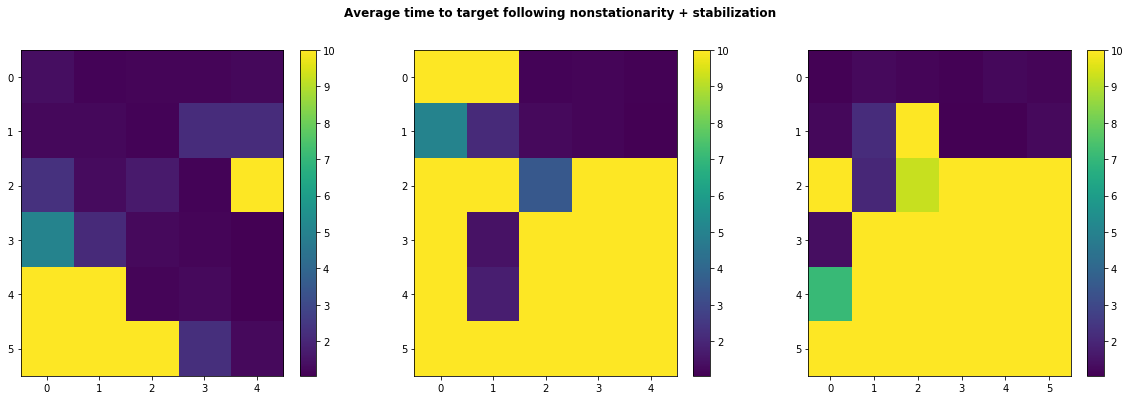

In [64]:
import matplotlib.pyplot as plt


plt_scores = np.median(scores_arr, axis = -1)

arg_kappa, arg_inflection, arg_exp = np.unravel_index(np.argmin(plt_scores), plt_scores.shape)

print('optimal kappa: ', sweep_opts['kappa'][arg_kappa])
print('optimal inflection: ', sweep_opts['inflection'][arg_inflection])
print('optimal exp: ', sweep_opts['exp'][arg_exp])

figSize(6, 20)
plt.subplot(1, 3, 1)
plt.imshow(plt_scores[arg_kappa, :, :], aspect = 'auto')
#plt.title('Fixed dimensionality = ' + str(d_sweep[arg_d]) + ' (best)')
#plt.ylabel('Threshold')
#plt.yticks(np.arange(len(thresh_sweep)), np.round(thresh_sweep, 3))
#plt.xlabel('B')
#plt.xticks(np.arange(len(B_sweep)), B_sweep)
plt.colorbar()

plt.subplot(1, 3, 2)
plt.imshow(plt_scores[:, arg_inflection, :], aspect = 'auto')
#plt.title('Fixed B = ' + str(B_sweep[arg_B]) + ' (best)')
#plt.xlabel('Threshold')
#plt.xticks(np.arange(len(thresh_sweep)), np.round(thresh_sweep, 3))
#plt.ylabel('Dimensionality')
#plt.yticks(np.arange(len(d_sweep)), d_sweep)
plt.colorbar()

plt.subplot(1, 3, 3)
plt.imshow(plt_scores[:, :, arg_exp], aspect = 'auto')
#plt.title('Fixed threshold = ' + str(np.round(thresh_sweep[arg_thresh], 3)) + ' (best)')
#plt.xlabel('B')
#plt.xticks(np.arange(len(B_sweep)), B_sweep)
#plt.ylabel('Dimensionality')
#plt.yticks(np.arange(len(d_sweep)), d_sweep)
plt.colorbar()

plt.suptitle('Average time to target following nonstationarity + stabilization', fontweight = 'bold')
plt.show()